# Antarctic sea ice concentration and CO2 emissions in CMIP6 
  
Katie Brennan  
March 6, 2020  

In [1]:
import xarray as xr 
import os
from glob import glob
import utils as ut
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
def get_hist_co2(institute, model, expt, ens, vartype, var, historical=True):
    if historical is True: 
        droot = '/glade/collections/cmip/CMIP6/CMIP'
    else:
        droot = '/glade/collections/cdg/data/CMIP6/PMIP'
    ddir = os.path.join(droot, institute, model, expt, ens, vartype, var)
    if vartype is 'Omon':
        dfiles = glob(ddir+'/gn/latest/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_gn_*.nc')
    elif vartype is 'SImon': 
        dfiles = glob(ddir+'/gn/latest/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_gn_*.nc')
    else:
        dfiles = glob(ddir+'/gr/**/*/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_gr_*.nc')
            
    ds = xr.open_mfdataset(dfiles, combine='by_coords')
    
    return ds

In [3]:
def get_hist_co2_local(institute, model, expt, ens, vartype, var, grid, historical=True):
    if historical is True: 
        droot = '/glade/work/mkbren/data/CMIP6/CMIP'
    else:
        droot = '/glade/work/mkbren/data/CMIP6/PMIP'
    ddir = os.path.join(droot, institute, model, expt, ens, vartype, var)
    if vartype is 'Omon':
        dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_'+grid+'*.nc')
    elif vartype is 'SImon': 
        dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_'+grid+'*.nc')
    else:
        dfiles = glob(ddir+'/gr/**/*/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'_'+grid+'*.nc')

    ds = xr.open_mfdataset(dfiles, combine='by_coords')
    
    return ds

In [105]:
def get_hist_co2_scratch(model, expt, ens, vartype, var, grid, historical=True): 
    if var is 'fgco2':
        droot = '/glade/scratch/apauling/co2-cmip6'
        if historical is True: 
            ddir = os.path.join(droot, 'normal')
            expt = 'historical'
        elif expt is 'ssp585': 
            ddir = os.path.join(droot, 'normal')
        else: 
            ddir = os.path.join(droot, 'esm')
            expt = 'esm-hist'
    elif var is 'siareas': 
        droot = '/glade/scratch/mkbren/cmip6-sia-co2'
        if historical is True: 
            ddir = os.path.join(droot, 'historical')
            expt = 'historical'
        elif expt is 'ssp585': 
            ddir = os.path.join(droot, 'ssp585')
       
    if vartype is 'Omon':
        dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')
    elif vartype is 'SImon': 
        dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')
    else:
        dfiles = glob(ddir+'/gr/**/*/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')

    ds = xr.open_mfdataset(dfiles, combine='by_coords')
    
    return ds

In [58]:
def find_lat_lon(ds):
    dimlist = [key for key in ds.dims]
    if 'nlat' in dimlist:
        dim_lat = 'nlat'
        dim_lon = 'nlon'
    else:
        dim_lat = 'lat'
        dim_lon = 'lon'
    return dim_lat, dim_lon 

In [59]:
def find_lat_lon(ds,var):
    print(var)
    dimlist = [key for key in ds.dims]
    if 'nlat' in dimlist:
        dim_lat = 'nlat'
        dim_lon = 'nlon'
    elif 'lat' in dimlist:
        dim_lat = 'lat'
        dim_lon = 'lon'
    elif 'x' in dimlist:
        dim_lat = 'x'
        dim_lon = 'y'
    elif 'i' in dimlist:
        dim_lat = 'i'
        dim_lon = 'j'
    else: 
        dim_lat = sorted(ds[var].dims)[1]
        dim_lon = sorted(ds[var].dims)[2]

    cor_lat=[]
    cor_lon=[]   

    lcoords = sorted(ds[var].coords._names)
    cor_lat = [val for i,val in enumerate(lcoords) if ('lat' in val)][0]
    cor_lon = [val for i,val in enumerate(lcoords) if ('lon' in val)][0]
    
    return dim_lat, dim_lon, cor_lat, cor_lon

In [60]:
def area_weighted_sum(data,dim_lat,dim_lon):
    """
    Compute area weighted sum of some CMIP6 data.

    Parameters
    ----------
    data : xarray DataArray
        DataArray containing the data to average.
        Assumes lat dimension/coordinate is called
        'lat' and lon dimension/coordinate is called
        'lon'

    Returns
    -------
    dout : xarray DataArray
        DataArray containing area-weighted sum of
        data. Has lost domensions of lat and lon

    """
    
    lat = data[dim_lat]
    coslat = np.cos(np.deg2rad(lat))
    
    dout = (data*coslat).sum((dim_lat, dim_lon))
    
    return dout

In [91]:
def preprocess_data(institute, model, expt, ens, vartype, var,grid,area_sum=False, historical=True, local=True):
    
    if local is True: 
        ds = get_hist_co2_local(institute, model, expt, ens, vartype, var, grid, historical)
    elif local is 'scratch':
        ds = get_hist_co2_scratch(model, expt, ens, vartype, var, grid, historical) 
    else: 
        ds = get_hist_co2(institute, model, expt, ens, vartype, var, historical)
    Var = ds[var]
    
    # Calculate seasonal means for each year: 
    var_rmn = Var.rolling(center=True, time=3).mean()
    var_seasonal = var_rmn.isel(time = slice(None,None,3))
    
    var_DJF = var_seasonal.isel(time=slice(None,None,4))
    var_MAM = var_seasonal.isel(time=slice(1,None,4))
    var_JJA = var_seasonal.isel(time=slice(2,None,4))
    var_SON = var_seasonal.isel(time=slice(3,None,4))
    
    years = var_DJF.time.dt.year
    
    if area_sum is False: 
        var_tot_DJF = var_DJF
        var_tot_MAM = var_MAM
        var_tot_JJA = var_JJA
        var_tot_SON = var_SON
        
    else: 
        #find dimension names: 
        [dim_lat, dim_lon, cor_lat,_] = find_lat_lon(ds, var)

        var_tot_DJF = area_weighted_sum(var_DJF.where(ds[cor_lat]<=-60.0), dim_lat, dim_lon).values
        var_tot_MAM = area_weighted_sum(var_MAM.where(ds[cor_lat]<=-60.0), dim_lat, dim_lon).values
        var_tot_JJA = area_weighted_sum(var_JJA.where(ds[cor_lat]<=-60.0), dim_lat, dim_lon).values
        var_tot_SON = area_weighted_sum(var_SON.where(ds[cor_lat]<=-60.0), dim_lat, dim_lon).values

    return var_tot_DJF, var_tot_MAM, var_tot_JJA, var_tot_SON, years

more fgco2 data: 
    
/glade/scratch/apauling/co2-cmip6/normal

In [ ]:
NorESM1', 'NorESM2-LM'

In [19]:
institute = 'NCAR'
model = 'CESM2'
expt = 'historical'
ens = 'r1i1p1f1'
vartype = 'Omon'
var = 'fgco2'
grid = 'gn'
historical = True
local = False
area_sum = True

In [20]:
if local is True: 
    ds2 = get_hist_co2_local(institute, model, expt, ens, vartype, var, grid, historical)
else: 
    ds2 = get_hist_co2(institute, model, expt, ens, vartype, var, historical)
Var = ds2[var]

# Calculate seasonal means for each year: 
var_rmn = Var.rolling(center=True, time=3).mean()
var_seasonal = var_rmn.isel(time = slice(None,None,3))

var_DJF = var_seasonal.isel(time=slice(None,None,4))
var_MAM = var_seasonal.isel(time=slice(1,None,4))
var_JJA = var_seasonal.isel(time=slice(2,None,4))
var_SON = var_seasonal.isel(time=slice(3,None,4))

years = var_DJF.time.dt.year

if area_sum is False: 
    var_tot_DJF = var_DJF
    var_tot_MAM = var_MAM
    var_tot_JJA = var_JJA
    var_tot_SON = var_SON

else: 
    #find dimension names: 
    [dim_lat2, dim_lon2, cord_lat2,_] = find_lat_lon(ds2, var)

    var_tot_DJF = area_weighted_sum(var_DJF.where(ds2[cord_lat2]<=-60.0), dim_lat2, dim_lon2).values
    var_tot_MAM = area_weighted_sum(var_MAM.where(ds2[cord_lat2]<=-60.0), dim_lat2, dim_lon2).values
    var_tot_JJA = area_weighted_sum(var_JJA.where(ds2[cord_lat2]<=-60.0), dim_lat2, dim_lon2).values
    var_tot_SON = area_weighted_sum(var_SON.where(ds2[cord_lat2]<=-60.0), dim_lat2, dim_lon2).values

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [58]:
dim_lat2, dim_lon2, cord_lat2

('j', 'time', 'latitude')

In [60]:
dimlist = [key for key in ds2.dims]
if 'nlat' in dimlist:
    dim_lat = 'nlat'
    dim_lon = 'nlon'
elif 'lat' in dimlist:
    dim_lat = 'lat'
    dim_lon = 'lon'
elif 'x' in dimlist:
    dim_lat = 'x'
    dim_lon = 'y'
elif 'i' in dimlist:
    dim_lat = 'i'
    dim_lon = 'j'
else: 
    dim_lat = sorted(ds2[var].dims)[1]
    dim_lon = sorted(ds2[var].dims)[2]

cor_lat=[]
cor_lon=[]   

lcoords = sorted(ds2[var].coords._names)
cor_lat = [val for i,val in enumerate(lcoords) if ('lat' in val)][0]
cor_lon = [val for i,val in enumerate(lcoords) if ('lon' in val)][0]

In [64]:
cor_lat, cor_lon

('latitude', 'longitude')

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.SouthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, -45, -90], crs=ccrs.PlateCarree())
#cs = si_data.siconc_seasonal_mn.isel(season=1).plot.contour('lon', 'lat',levels=[15,95], ax=axs, colors='0.5',transform=ccrs.PlateCarree())
#axs.clabel(cs, inline=1, fontsize=10)
axs.pcolormesh('lon', 'lat',fgco2_hist_DJF, ax=axs, transform=ccrs.PlateCarree())

In [ ]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
expt = 'historical'
ens = 'r1i1p1f1'
vartype = 'SImon'
var = 'siareas'
grid = 'gn'
historical = True
local = True
area_sum = False

In [ ]:
if local is True: 
    ds = get_hist_co2_local(institute, model, expt, ens, vartype, var, grid, historical)
else: 
    ds = get_hist_co2(institute, model, expt, ens, vartype, var, historical)
Var = ds[var]

# Calculate seasonal means for each year: 
var_rmn = Var.rolling(center=True, time=3).mean()
var_seasonal = var_rmn.isel(time = slice(None,None,3))

var_DJF = var_seasonal.isel(time=slice(None,None,4))
var_MAM = var_seasonal.isel(time=slice(1,None,4))
var_JJA = var_seasonal.isel(time=slice(2,None,4))
var_SON = var_seasonal.isel(time=slice(3,None,4))

years = var_DJF.time.dt.year

if area_sum is False: 
    var2_tot_DJF = var_DJF
    var2_tot_MAM = var_MAM
    var2_tot_JJA = var_JJA
    var2_tot_SON = var_SON

else: 
    #find dimension names: 
    [dim_lat, dim_lon, cord_lat, cord_lon] = find_lat_lon(ds, var)

    var2_tot_DJF = area_weighted_sum(var_DJF.where(ds[cord_lat2]<-60.0), dim_lat, dim_lon).values
    var2_tot_MAM = area_weighted_sum(var_MAM.where(ds[cord_lat2]<-60.0), dim_lat, dim_lon).values
    var2_tot_JJA = area_weighted_sum(var_JJA.where(ds[cord_lat2]<-60.0), dim_lat, dim_lon).values
    var2_tot_SON = area_weighted_sum(var_SON.where(ds[cord_lat2]<-60.0), dim_lat, dim_lon).values

In [ ]:
var_tot_DJF

In [ ]:
var_rmn = Var.rolling(center=True, time=3).mean()
var_seasonal = var_rmn.isel(time = slice(None,None,3))
var_DJF = var_seasonal.isel(time=slice(None,None,4))
var_DJF,var_rmn,var_seasonal.time

In [ ]:
(1980/4)/3

In [103]:
institute = 'NCAR'
model = 'CESM2'
expt = 'ssp585'
ens = 'r1i1p1f1'
vartype = 'Omon'
var = 'fgco2'
grid = 'gn',
area_sum=False
historical=False
local='scratch'

In [104]:
if var is 'fgco2':
    droot = '/glade/scratch/apauling/co2-cmip6'
    if historical is True: 
        ddir = os.path.join(droot, 'normal')
        expt = 'historical'
    elif expt is 'ssp585': 
        ddir = os.path.join(droot, 'normal')
    else: 
        ddir = os.path.join(droot, 'esm')
        expt = 'esm-hist'
elif var is 'siareas': 
    droot = '/glade/scratch/mkbren/cmip6-sia-co2'
    if historical is True: 
        ddir = os.path.join(droot, 'historical')
        expt = 'historical'
    elif expt is 'ssp585': 
        ddir = os.path.join(droot, 'ssp585')

if vartype is 'Omon':
    dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')
elif vartype is 'SImon': 
    dfiles = glob(ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')
else:
    dfiles = glob(ddir+'/gr/**/*/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc')

ds = xr.open_mfdataset(dfiles, combine='by_coords')

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [100]:
ddir+'/'+var+'_'+vartype+'_'+model+'_'+expt+'_'+ens+'*.nc'

'/glade/scratch/apauling/co2-cmip6/ssp585/fgco2_Omon_CESM2_ssp585_r1i1p1f1*.nc'

In [ ]:
siareas_SImon_CESM2_ssp585_r1i1p1f1_gn_201501-206412.nc

In [87]:
if local is True: 
    ds = get_hist_co2_local(institute, model, expt, ens, vartype, var, grid, historical)
elif local is 'scratch':
    print('hi')
    ds = get_hist_co2_scratch(model, expt, ens, vartype, var, grid, historical) 
else: 
    ds = get_hist_co2(institute, model, expt, ens, vartype, var, historical)
Var = ds[var]

hi


In [35]:
[dim_lat2, dim_lon2, cord_lat2,_] = find_lat_lon(ds, var)
dim_lat2, dim_lon2, cord_lat2

fgco2


('i', 'j', 'latitude')

In [42]:
[fgco2_hist_MPI_DJF, fgco2_hist_MPI_MAM, 
 fgco2_hist_MPI_JJA, fgco2_hist_MPI_SON, years_hist] = preprocess_data('MPI', 'MPI-ESM1-2-HR', 'historical', 
                                                                       'r1i1p1f1', 'Omon', 'fgco2', 'gn',
                                                                       area_sum=True, historical=True, local='scratch')

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [43]:
fgco2_hist_MPI_DJF.shape

(165,)

### Load all Historical model output: 

#### INM

In [9]:
[fgco2_hist_INM_DJF, fgco2_hist_INM_MAM, 
 fgco2_hist_INM_JJA, fgco2_hist_INM_SON, years_hist] = preprocess_data('INM', 'INM-CM4-8', 'historical',
                                                                       'r1i1p1f1','Omon','fgco2','gr1',
                                                                       area_sum=True, historical=True, local=True)

[sia_hist_INM_DJF, sia_hist_INM_MAM, 
 sia_hist_INM_JJA, sia_hist_INM_SON, years_hist] = preprocess_data('INM', 'INM-CM4-8', 'historical', 
                                                                   'r1i1p1f1','SImon','siareas','gr1',
                                                                   area_sum=False, historical=True, local=True)

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### MPI

In [10]:
[fgco2_hist_MPI_DJF, fgco2_hist_MPI_MAM, 
 fgco2_hist_MPI_JJA, fgco2_hist_MPI_SON, years_hist] = preprocess_data('MPI', 'MPI-ESM1-2-HR', 'historical', 
                                                                       'r1i1p1f1', 'Omon', 'fgco2', 'gn',
                                                                       area_sum=True, historical=True, local='scratch')

[sia_hist_MPI_DJF, sia_hist_MPI_MAM, 
 sia_hist_MPI_JJA, sia_hist_MPI_SON, years_hist] = preprocess_data('MPI', 'MPI-ESM1-2-HR', 'historical', 
                                                                   'r1i1p1f1', 'SImon', 'siareas', 'gn',
                                                                   area_sum=False, historical=True, local='scratch')

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### ACCESS: 

In [11]:
[fgco2_hist_ACC_DJF, fgco2_hist_ACC_MAM, 
 fgco2_hist_ACC_JJA, fgco2_hist_ACC_SON, years_hist] = preprocess_data('ACC', 'ACCESS-ESM1-5', 'historical', 
                                                                       'r1i1p1f1', 'Omon', 'fgco2', 'gn',
                                                                       area_sum=True, historical=True, local='scratch')

[sia_hist_ACC_DJF, sia_hist_ACC_MAM, 
 sia_hist_ACC_JJA, sia_hist_ACC_SON, years_hist] = preprocess_data('ACC', 'ACCESS-ESM1-5', 'historical', 
                                                                   'r1i1p1f1', 'SImon', 'siareas', 'gn',
                                                                   area_sum=False, historical=True, local='scratch')

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### MRI

In [12]:
# [fgco2_hist_MRI_DJF, fgco2_hist_MRI_MAM, 
#  fgco2_hist_MRI_JJA, fgco2_hist_MRI_SON, years_hist] = preprocess_data('MRI', 'MRI-ESM2-0', 'historical', 
#                                                                        'r1i1p1f1', 'Omon', 'fgco2', 'gm',
#                                                                        area_sum=True, historical=True, local='scratch')

# [sia_hist_MRI_DJF, sia_hist_MRI_MAM, 
#  sia_hist_MRI_JJA, sia_hist_MRI_SON, years_hist] = preprocess_data('MRI', 'MRI-ESM2-0', 'historical', 
#                                                                    'r1i1p1f1', 'SImon', 'siareas', 'gm',
#                                                                    area_sum=False, historical=True, local='scratch')

#### IPSL

In [13]:
[fgco2_hist_IPSL_DJF, fgco2_hist_IPSL_MAM, 
 fgco2_hist_IPSL_JJA, fgco2_hist_IPSL_SON, years_hist] = preprocess_data('IPSL', 'IPSL-CM6A-LR', 'historical',
                                                                         'r1i1p1f1','Omon','fgco2','gn',
                                                                         area_sum=True, historical=True, local=True)

[sia_hist_IPSL_DJF, sia_hist_IPSL_MAM, 
 sia_hist_IPSL_JJA, sia_hist_IPSL_SON, years_hist] = preprocess_data('IPSL', 'IPSL-CM6A-LR', 'historical', 
                                                                    'r1i1p1f1','SImon','siareas','gn',
                                                                     area_sum=False, historical=True, local=True)

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### CESM2

In [14]:
[fgco2_hist_DJF, fgco2_hist_MAM, 
 fgco2_hist_JJA, fgco2_hist_SON, years_hist] = preprocess_data('NCAR', 'CESM2', 'historical',
                                                               'r1i1p1f1','Omon','fgco2','gn',
                                                               area_sum=True, historical=True, local=False)

[sia_hist_DJF, sia_hist_MAM, 
 sia_hist_JJA, sia_hist_SON, years_hist] = preprocess_data('NCAR', 'CESM2', 'historical', 
                                                           'r1i1p1f1','SImon','siareas','gn', 
                                                           area_sum=False, historical=True, local=False)

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


#### NorESM1

In [15]:
[fgco2_hist_Nor_DJF, fgco2_hist_Nor_MAM, 
 fgco2_hist_Nor_JJA, fgco2_hist_Nor_SON, years_hist] = preprocess_data('NorESM1', 'NorESM2-LM', 'historical',
                                                                       'r1i1p1f1','Omon','fgco2','gn',
                                                                       area_sum=True, historical=True, local=True)

[sia_hist_Nor_DJF, sia_hist_Nor_MAM, 
 sia_hist_Nor_JJA, sia_hist_Nor_SON, years_hist] = preprocess_data('NorESM1', 'NorESM2-LM', 'historical', 
                                                                   'r1i1p1f1','SImon','siareas','gn',
                                                                   area_sum=False, historical=True, local=True)

fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Load Historical run with carbon cycle turned on (esm-historical) model output: 

#### CESM2:

In [89]:
[fgco2_esmhist_DJF, fgco2_esmhist_MAM, 
 fgco2_esmhist_JJA, fgco2_esmhist_SON, years] = preprocess_data('NCAR', 'CESM2', 'esm-hist',
                                                                'r1i1p1f1','Omon','fgco2','gn',
                                                                area_sum=True, historical=True, local=False)

[sia_esmhist_DJF, sia_esmhist_MAM, 
 sia_esmhist_JJA, sia_esmhist_SON, years] = preprocess_data('NCAR', 'CESM2', 'esm-hist', 
                                                            'r1i1p1f1','SImon','siareas','gn',
                                                            area_sum=False, historical=True, local=False)

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


### Load midHolocene model output: 

#### CESM2:

In [28]:
[fgco2_holo_DJF, fgco2_holo_MAM, 
 fgco2_holo_JJA, fgco2_holo_SON, years_holo] = preprocess_data('NCAR', 'CESM2', 'midHolocene',
                                                               'r1i1p1f1','Omon','fgco2','gn',
                                                               area_sum=True, historical=False,local=False)

[sia_holo_DJF, sia_holo_MAM, 
 sia_holo_JJA, sia_holo_SON, years_holo] = preprocess_data('NCAR', 'CESM2', 'midHolocene', 
                                                           'r1i1p1f1','SImon','siareas','gn',
                                                           area_sum=False, historical=False, local=False)

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


### Load Last Interglacial (lig27k) model output: 

#### CESM2:

In [27]:
[fgco2_lig_DJF, fgco2_lig_MAM, 
 fgco2_lig_JJA, fgco2_lig_SON, years_lig] = preprocess_data('NCAR', 'CESM2', 'lig127k',
                                                           'r1i1p1f1','Omon','fgco2','gn',
                                                            area_sum=True, historical=False, local=False)

[sia_lig_DJF, sia_lig_MAM, 
 sia_lig_JJA, sia_lig_SON, years_lig] = preprocess_data('NCAR', 'CESM2', 'lig127k', 
                                                       'r1i1p1f1','SImon','siareas','gn',
                                                        area_sum=False, historical=False, local=False)

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


### Load Last Glacial Maximum model output: 

#### CESM2:

In [ ]:
# [fgco2_lig_DJF, fgco2_lig_MAM, 
#  fgco2_lig_JJA, fgco2_lig_SON, years_lig] = preprocess_data('NCAR', 'CESM2', 'lig127k',
#                                                            'r1i1p1f1','Omon','fgco2','gn',
#                                                             area_sum=True, historical=False, local=False)

# [sia_lig_DJF, sia_lig_MAM, 
#  sia_lig_JJA, sia_lig_SON, years_lig] = preprocess_data('NCAR', 'CESM2', 'lig127k', 
#                                                        'r1i1p1f1','SImon','siareas','gn',
#                                                         area_sum=False, historical=False, local=False)

### Load Abrupt 4xCO2 model output: 

#### CESM2:

In [39]:
[fgco2_4co2_DJF, fgco2_4co2_MAM, 
 fgco2_4co2_JJA, fgco2_4co2_SON, years_4co2] = preprocess_data('NCAR', 'CESM2', 'abrupt-4xCO2',
                                                           'r1i1p1f1','Omon','fgco2','gn',
                                                            area_sum=True, historical=True, local=False)

[sia_4co2_DJF, sia_4co2_MAM, 
 sia_4co2_JJA, sia_4co2_SON, years_4co2] = preprocess_data('NCAR', 'CESM2', 'abrupt-4xCO2', 
                                                       'r1i1p1f1','SImon','siareas','gn',
                                                        area_sum=False, historical=True, local=False)

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


### Load SSP585 model output: 

#### CESM2:

In [106]:
[fgco2_ssp585_DJF, fgco2_ssp585_MAM, 
 fgco2_ssp585_JJA, fgco2_ssp585_SON, years_ssp585] = preprocess_data('NCAR', 'CESM2', 'ssp585',
                                                                     'r1i1p1f1','Omon','fgco2','gn',
                                                                    area_sum=True, historical=False, local='scratch')

[sia_ssp585_DJF, sia_ssp585_MAM, 
 sia_ssp585_JJA, sia_ssp585_SON, years_ssp585] = preprocess_data('NCAR', 'CESM2', 'ssp585', 
                                                                 'r1i1p1f1','SImon','siareas','gn',
                                                                 area_sum=False, historical=False, local='scratch')

/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


fgco2


/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/mkbren/my_npl_clone/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siareas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [97]:
sia_ssp585_DJF.shape, fgco2_ssp585_DJF.shape

((86,), (165,))

# Plotting: 

### Historical runs across models: 

Text(0.5,1,'SON')

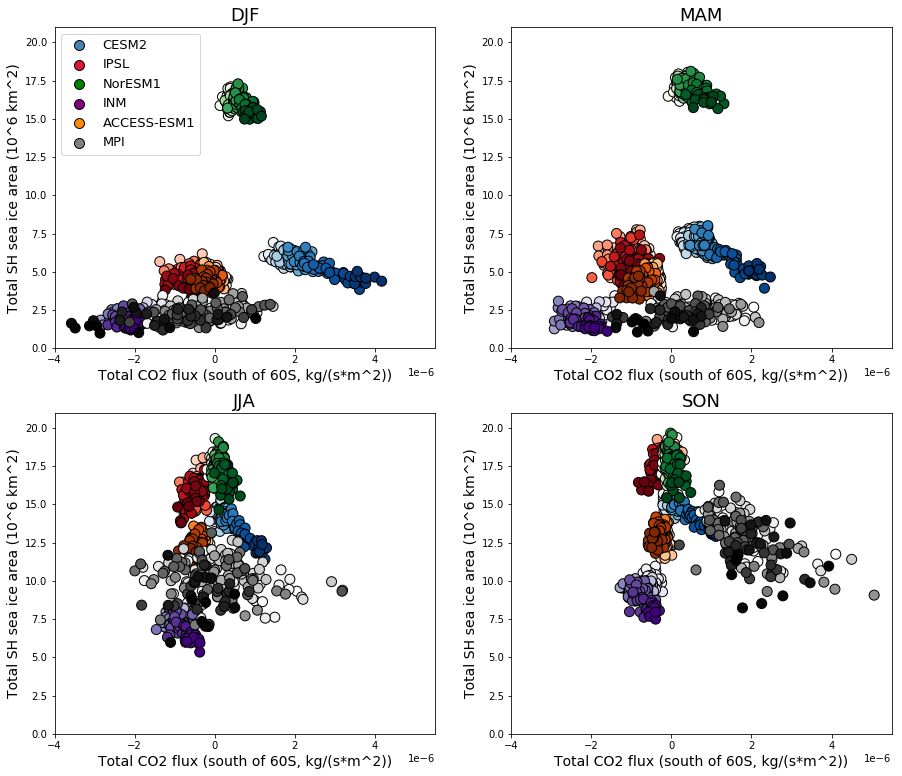

In [24]:
fig = plt.figure(1,figsize=(15, 13))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(fgco2_hist_DJF,sia_hist_DJF,100,c=years_hist, cmap = 'Blues',edgecolor='k',label='CESM2')
ax1.scatter(fgco2_hist_IPSL_DJF,sia_hist_IPSL_DJF,100,c=years_hist, cmap = 'Reds',edgecolor='k',label='IPSL')
ax1.scatter(fgco2_hist_Nor_DJF,sia_hist_Nor_DJF,100,c=years_hist, cmap = 'Greens',edgecolor='k',label='NorESM1')
ax1.scatter(fgco2_hist_INM_DJF,sia_hist_INM_DJF,100,c=years_hist, cmap = 'Purples',edgecolor='k',label='INM')
ax1.scatter(fgco2_hist_ACC_DJF,sia_hist_ACC_DJF,100,c=years_hist, cmap = 'Oranges',edgecolor='k',label='ACCESS-ESM1')
ax1.scatter(fgco2_hist_MPI_DJF,sia_hist_MPI_DJF,100,c=years_hist, cmap = 'Greys',edgecolor='k',label='MPI')
plt.xlim(-4e-06,5.5e-06)
plt.ylim(0,21)
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax1.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax1.set_title('DJF', fontsize=18)

leg = ax1.legend(fontsize=13, loc='upper left')
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict['CESM2'].set_color('steelblue')
hl_dict['CESM2'].set_edgecolor('k')
hl_dict['IPSL'].set_color('crimson')
hl_dict['IPSL'].set_edgecolor('k')
hl_dict['INM'].set_color('purple')
hl_dict['INM'].set_edgecolor('k')
hl_dict['NorESM1'].set_color('g')
hl_dict['NorESM1'].set_edgecolor('k')
hl_dict['ACCESS-ESM1'].set_color('darkorange')
hl_dict['ACCESS-ESM1'].set_edgecolor('k')
hl_dict['MPI'].set_color('grey')
hl_dict['MPI'].set_edgecolor('k')

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(fgco2_hist_MAM,sia_hist_MAM,100,c=years_hist, cmap = 'Blues',edgecolor='k',label='CESM2')
ax2.scatter(fgco2_hist_IPSL_MAM,sia_hist_IPSL_MAM,100,c=years_hist, cmap = 'Reds',edgecolor='k',label='IPSL')
ax2.scatter(fgco2_hist_Nor_MAM,sia_hist_Nor_MAM,100,c=years_hist, cmap = 'Greens',edgecolor='k',label='NorESM1')
ax2.scatter(fgco2_hist_INM_MAM,sia_hist_INM_MAM,100,c=years_hist, cmap = 'Purples',edgecolor='k',label='INM')
ax2.scatter(fgco2_hist_ACC_MAM,sia_hist_ACC_MAM,100,c=years_hist, cmap = 'Oranges',edgecolor='k',label='ACCESS-ESM1-5')
ax2.scatter(fgco2_hist_MPI_MAM,sia_hist_MPI_MAM,100,c=years_hist, cmap = 'Greys',edgecolor='k',label='MPI')
plt.xlim(-4e-06,5.5e-06)
plt.ylim(0,21)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax2.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax2.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax2.set_title('MAM', fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(fgco2_hist_JJA,sia_hist_JJA,100,c=years_hist, cmap = 'Blues',edgecolor='k')
ax3.scatter(fgco2_hist_IPSL_JJA,sia_hist_IPSL_JJA,100,c=years_hist, cmap = 'Reds',edgecolor='k')
ax3.scatter(fgco2_hist_Nor_JJA,sia_hist_Nor_JJA,100,c=years_hist, cmap = 'Greens',edgecolor='k')
ax3.scatter(fgco2_hist_INM_JJA,sia_hist_INM_JJA,100,c=years_hist, cmap = 'Purples',edgecolor='k')
ax3.scatter(fgco2_hist_ACC_JJA,sia_hist_ACC_JJA,100,c=years_hist, cmap = 'Oranges',edgecolor='k')
ax3.scatter(fgco2_hist_MPI_JJA,sia_hist_MPI_JJA,100,c=years_hist, cmap = 'Greys',edgecolor='k')
plt.xlim(-4e-06,5.5e-06)
plt.ylim(0,21)
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax3.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax3.set_title('JJA', fontsize=18)

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(fgco2_hist_SON,sia_hist_SON,100,c=years_hist, cmap = 'Blues',label='CESM2',edgecolor='k')
ax4.scatter(fgco2_hist_IPSL_SON,sia_hist_IPSL_SON,100,c=years_hist, cmap = 'Reds',label='IPSL',edgecolor='k')
ax4.scatter(fgco2_hist_Nor_SON,sia_hist_Nor_SON,100,c=years_hist, cmap = 'Greens',label='NorESM1',edgecolor='k')
ax4.scatter(fgco2_hist_INM_SON,sia_hist_INM_SON,100,c=years_hist, cmap = 'Purples',label='INM',edgecolor='k')
ax4.scatter(fgco2_hist_ACC_SON,sia_hist_ACC_SON,100,c=years_hist, cmap = 'Oranges',label='ACCESS-ESM1-5',edgecolor='k')
ax4.scatter(fgco2_hist_MPI_SON,sia_hist_MPI_SON,100,c=years_hist, cmap = 'Greys',label='MPI',edgecolor='k')
plt.xlim(-4e-06,5.5e-06)
plt.ylim(0,21)
ax4.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax4.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax4.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax4.set_title('SON', fontsize=18)

### Different experiments for CESM2: 

In [34]:
fgco2_4co2_DJF.shape, sia_4co2_DJF.shape

((999,), (999,))

In [94]:
labelA = 'Historical'
labelB = 'Abrupt 4xCO2'
labelC = 'Last interglacial (lig127k)'
labelD = 'mid-Holocene'
labelE = 'ssp585'

#years_4co2 = np.arange(1,1000,1)

Text(0.5,1,'SON')

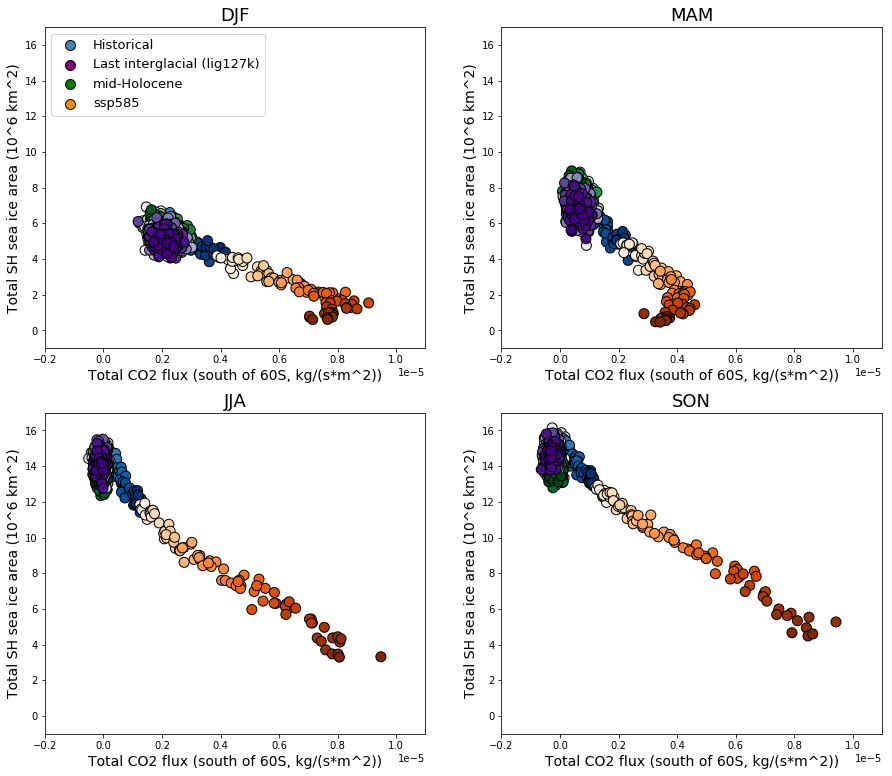

In [113]:
fig = plt.figure(1,figsize=(15, 13))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(fgco2_hist_DJF,sia_hist_DJF,100,c=years_hist, cmap = 'Blues',edgecolor='k',label=labelA)
#ax1.scatter(fgco2_4co2_DJF,sia_4co2_DJF,100,c=years_4co2, cmap = 'Reds',edgecolor='k',label=labelB)
ax1.scatter(fgco2_lig_DJF,sia_lig_DJF,100,c=years_lig, cmap = 'Greens',edgecolor='k',label=labelC)
ax1.scatter(fgco2_holo_DJF,sia_holo_DJF,100,c=years_holo, cmap = 'Purples',edgecolor='k',label=labelD)
ax1.scatter(fgco2_ssp585_DJF,sia_ssp585_DJF,100,c=years_ssp585, cmap = 'Oranges',edgecolor='k',label=labelE)
# ax1.scatter(fgco2_hist_MPI_DJF,sia_hist_MPI_DJF,100,c=years_hist, cmap = 'Greys',edgecolor='k',label='MPI')
plt.xlim(-2e-06,11e-06)
plt.ylim(-1,17)
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax1.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax1.set_title('DJF', fontsize=18)

leg = ax1.legend(fontsize=13, loc='upper left')
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict[labelA].set_color('steelblue')
hl_dict[labelA].set_edgecolor('k')
# hl_dict[labelB].set_color('crimson')
# hl_dict[labelB].set_edgecolor('k')
hl_dict[labelC].set_color('purple')
hl_dict[labelC].set_edgecolor('k')
hl_dict[labelD].set_color('g')
hl_dict[labelD].set_edgecolor('k')
hl_dict[labelE].set_color('darkorange')
hl_dict[labelE].set_edgecolor('k')

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(fgco2_hist_MAM,sia_hist_MAM,100,c=years_hist, cmap = 'Blues',edgecolor='k',label=labelA)
#ax2.scatter(fgco2_4co2_MAM,sia_4co2_MAM,100,c=years_4co2, cmap = 'Reds',edgecolor='k',label=labelB)
ax2.scatter(fgco2_lig_MAM,sia_lig_MAM,100,c=years_lig, cmap = 'Greens',edgecolor='k',label=labelC)
ax2.scatter(fgco2_holo_MAM,sia_holo_MAM,100,c=years_holo, cmap = 'Purples',edgecolor='k',label=labelD)
ax2.scatter(fgco2_ssp585_MAM,sia_ssp585_MAM,100,c=years_ssp585, cmap = 'Oranges',edgecolor='k',label=labelE)
# ax2.scatter(fgco2_hist_MPI_MAM,sia_hist_MPI_MAM,100,c=years_hist, cmap = 'Greys',edgecolor='k',label='MPI')
plt.xlim(-2e-06,11e-06)
plt.ylim(-1,17)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax2.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax2.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax2.set_title('MAM', fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(fgco2_hist_JJA,sia_hist_JJA,100,c=years_hist, cmap = 'Blues',edgecolor='k')
#ax3.scatter(fgco2_4co2_JJA,sia_4co2_JJA,100,c=years_4co2, cmap = 'Reds',edgecolor='k')
ax3.scatter(fgco2_lig_JJA,sia_lig_JJA,100,c=years_lig, cmap = 'Greens',edgecolor='k')
ax3.scatter(fgco2_holo_JJA,sia_holo_JJA,100,c=years_holo, cmap = 'Purples',edgecolor='k')
ax3.scatter(fgco2_ssp585_JJA,sia_ssp585_JJA,100,c=years_ssp585, cmap = 'Oranges',edgecolor='k')
# ax3.scatter(fgco2_hist_MPI_JJA,sia_hist_MPI_JJA,100,c=years_hist, cmap = 'Greys',edgecolor='k')
plt.xlim(-2e-06,11e-06)
plt.ylim(-1,17)
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax3.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax3.set_title('JJA', fontsize=18)

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(fgco2_hist_SON,sia_hist_SON,100,c=years_hist, cmap = 'Blues',label=labelA,edgecolor='k')
#ax4.scatter(fgco2_4co2_SON,sia_4co2_SON,100,c=years_4co2, cmap = 'Reds',label=labelB,edgecolor='k')
ax4.scatter(fgco2_lig_SON,sia_lig_SON,100,c=years_lig, cmap = 'Greens',label=labelC,edgecolor='k')
ax4.scatter(fgco2_holo_SON,sia_holo_SON,100,c=years_holo, cmap = 'Purples',label=labelD,edgecolor='k')
ax4.scatter(fgco2_ssp585_SON,sia_ssp585_SON,100,c=years_ssp585, cmap = 'Oranges',label=labelE,edgecolor='k')
# ax4.scatter(fgco2_hist_MPI_SON,sia_hist_MPI_SON,100,c=years_hist, cmap = 'Greys',label='MPI',edgecolor='k')
plt.xlim(-2e-06,11e-06)
plt.ylim(-1,17)
ax4.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax4.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax4.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax4.set_title('SON', fontsize=18)

Text(0.5,1,'CESM2: Historical vs. lig27k (black-outline)')

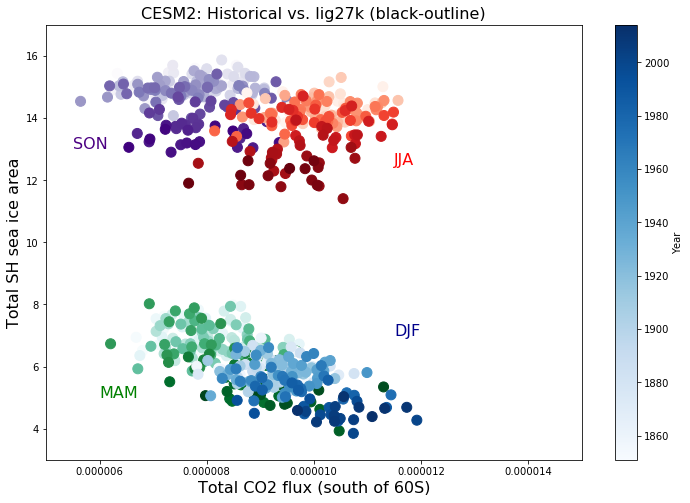

In [13]:
fig = plt.figure(1,figsize=(15, 13))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(fgco2_hist_DJF,sia_hist_DJF,100,c=years_hist, cmap = 'Blues',edgecolor='k')
ax1.scatter(fgco2_lig_DJF,sia_hist_IPSL_DJF,100,c=years_hist, cmap = 'Reds',edgecolor='k')
# ax1.scatter(fgco2_hist_Nor_DJF,sia_hist_Nor_DJF,100,c=years_hist, cmap = 'Greens',edgecolor='k')
# ax1.scatter(fgco2_hist_INM_DJF,sia_hist_INM_DJF,100,c=years_hist, cmap = 'Purples',edgecolor='k')
plt.xlim(-3.5e-06,4.5e-06)
plt.ylim(0,21)
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax1.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax1.set_title('DJF', fontsize=18)

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(fgco2_hist_MAM,sia_hist_MAM,100,c=years_hist, cmap = 'Blues',edgecolor='k')
ax2.scatter(fgco2_lig_MAM,sia_hist_IPSL_MAM,100,c=years_hist, cmap = 'Reds',edgecolor='k')
# ax2.scatter(fgco2_hist_Nor_MAM,sia_hist_Nor_MAM,100,c=years_hist, cmap = 'Greens',edgecolor='k')
# ax2.scatter(fgco2_hist_INM_MAM,sia_hist_INM_MAM,100,c=years_hist, cmap = 'Purples',edgecolor='k')
plt.xlim(-3.5e-06,4.5e-06)
plt.ylim(0,21)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax2.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax2.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax2.set_title('MAM', fontsize=18)

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(fgco2_hist_JJA,sia_hist_JJA,100,c=years_hist, cmap = 'Blues',edgecolor='k')
ax3.scatter(fgco2_lig_JJA,sia_hist_IPSL_JJA,100,c=years_hist, cmap = 'Reds',edgecolor='k')
# ax3.scatter(fgco2_lig_JJA,sia_hist_Nor_JJA,100,c=years_hist, cmap = 'Greens',edgecolor='k')
# ax3.scatter(fgco2_hist_INM_JJA,sia_hist_INM_JJA,100,c=years_hist, cmap = 'Purples',edgecolor='k')
plt.xlim(-3.5e-06,4.5e-06)
plt.ylim(0,21)
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax3.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax3.set_title('JJA', fontsize=18)

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(fgco2_hist_SON,sia_hist_SON,100,c=years_hist, cmap = 'Blues',label='CESM2 - historical',edgecolor='k')
ax4.scatter(fgco2_lig_SON,sia_hist_IPSL_SON,100,c=years_hist, cmap = 'Reds',label='CESM2 - lig27k',edgecolor='k')
# ax4.scatter(fgco2_hist_Nor_SON,sia_hist_Nor_SON,100,c=years_hist, cmap = 'Greens',label='NorESM1',edgecolor='k')
# ax4.scatter(fgco2_hist_INM_SON,sia_hist_INM_SON,100,c=years_hist, cmap = 'Purples',label='INM',edgecolor='k')
plt.xlim(-3.5e-06,4.5e-06)
plt.ylim(0,21)
ax4.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax4.set_xlabel('Total CO2 flux (south of 60S, kg/(s*m^2))',fontsize=14)
ax4.set_ylabel('Total SH sea ice area (10^6 km^2)',fontsize=14)
ax4.set_title('SON', fontsize=18)

leg = ax4.legend(fontsize=16, loc='lower right')
hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
hl_dict['CESM2 - historical'].set_color('steelblue')
hl_dict['CESM2 - historical'].set_edgecolor('k')
hl_dict['CESM2 - lig27k'].set_color('crimson')
hl_dict['CESM2 - lig27k'].set_edgecolor('k')
# hl_dict['INM'].set_color('purple')
# hl_dict['INM'].set_edgecolor('k')
# hl_dict['NorESM1'].set_color('g')
# hl_dict['NorESM1'].set_edgecolor('k')

Text(0.5,1,'Historical vs. ESM-Historical (black-outline)')

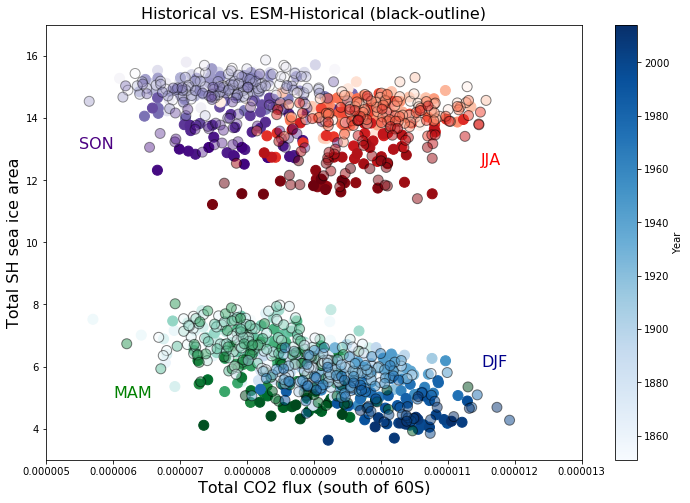

In [101]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(fgco2_esmhist_SON,sia_esmhist_SON,100,c=years, cmap = 'Purples')
plt.scatter(fgco2_esmhist_JJA,sia_esmhist_JJA,100,c=years, cmap = 'Reds')
plt.scatter(fgco2_esmhist_MAM,sia_esmhist_MAM,100,c=years, cmap = 'BuGn')
plt.scatter(fgco2_esmhist_DJF,sia_esmhist_DJF,100,c=years, cmap = 'Blues')

plt.colorbar(label='Year')

plt.scatter(fgco2_hist_SON,sia_hist_SON,100,c=years, cmap = 'Purples',alpha=0.4,edgecolor='k')
plt.scatter(fgco2_hist_JJA,sia_hist_JJA,100,c=years, cmap = 'Reds',alpha=0.5,edgecolor='k')
plt.scatter(fgco2_hist_MAM,sia_hist_MAM,100,c=years, cmap = 'BuGn',alpha=0.5,edgecolor='k')
plt.scatter(fgco2_hist_DJF,sia_hist_DJF,100,c=years, cmap = 'Blues',alpha=0.5,edgecolor='k')

plt.xlim(5e-06,13e-06)
plt.ylim(3,17)

plt.text(11.5e-6, 6, 'DJF', fontsize=16,color='darkblue')
plt.text(6e-6, 5, 'MAM', fontsize=16,color='g')
plt.text(11.5e-6, 12.5, 'JJA', fontsize=16,color='r')
plt.text(5.5e-6, 13, 'SON', fontsize=16,color='indigo')

plt.xlabel('Total CO2 flux (south of 60S)',fontsize=16)
plt.ylabel('Total SH sea ice area',fontsize=16)
plt.title('Historical vs. ESM-Historical (black-outline)',fontsize=16)

In [ ]:
# Historical runs without carbon cycle turnend on 
fig = plt.figure(figsize=(12, 8))
plt.scatter(fgco2_tot_SON,sia_SON,100,c=fgco2_tot_SON.time.dt.year, cmap = 'Purples')
plt.scatter(fgco2_tot_JJA,sia_JJA,100,c=fgco2_tot_JJA.time.dt.year, cmap = 'Reds')
plt.scatter(fgco2_tot_MAM,sia_MAM,100,c=fgco2_tot_MAM.time.dt.year, cmap = 'BuGn')
plt.scatter(fgco2_tot_DJF,sia_DJF,100,c=fgco2_tot_DJF.time.dt.year, cmap = 'Blues')

plt.colorbar(label='Year')
plt.xlim(-1e-06,5e-06)
plt.ylim(3.5,17)

plt.text(3.7e-6, 5.0, 'DJF', fontsize=16,color='darkblue')
plt.text(0, 5.5, 'MAM', fontsize=16,color='g')
plt.text(0.2e-6, 12, 'JJA', fontsize=16,color='r')
plt.text(1.1e-6, 14, 'SON', fontsize=16,color='indigo')


plt.xlabel('Total CO2 flux (south of 60S)',fontsize=16)
plt.ylabel('Total SH sea ice area',fontsize=16)
plt.title('All seasons',fontsize=16)

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.SouthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, -45, -90], crs=ccrs.PlateCarree())
#cs = si_data.siconc_seasonal_mn.isel(season=1).plot.contour('lon', 'lat',levels=[15,95], ax=axs, colors='0.5',transform=ccrs.PlateCarree())
axs.clabel(cs, inline=1, fontsize=10)
plt.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree())

In [ ]:
# Calculate seasonal mean across all years: 
fgco2_seasonal_mn = fgco2.groupby('time.season').mean('time')
siconc_seasonal_mn = siconc.groupby('time.season').mean('time')

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
axs = plt.axes(projection=ccrs.SouthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, -90, -40], crs=ccrs.PlateCarree())
cs = siconc_seasonal_mn[:,:100,:].isel(season=1).plot.contour('lon', 'lat',levels=[15,95], 
                                                              ax=axs, colors='0.5',transform=ccrs.PlateCarree())
axs.clabel(cs, inline=1, fontsize=10)
fgco2_seasonal_mn[:,:100,:].isel(season=1).plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree())

In [ ]:
plt.scatter(years,fgco2_tot_DJF)
plt.ylim(0,3e-06)
plt.title('Total CO2 flux: DJF')

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(fgco2_tot_DJF,sia_DJF,100,c=fgco2_tot_DJF.time.dt.year, cmap = 'cool')
plt.colorbar(label='Year')
plt.xlim(1e-06,5e-06)
plt.ylim(3.5,7.4)
plt.xlabel('Total CO2 flux',fontsize=16)
plt.ylabel('Total sea ice area',fontsize=16)
plt.title('DJF',fontsize=16)